In [1]:
# Bibliotecas necessárias
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

In [2]:
# Carregar Google Drive (Opcional, remover comentário das linhas)
from google.colab import drive
import os

# Montar o diretório do projeto
drive.mount('/content/drive')

os.chdir('/content/drive/MyDrive/ML_Salvador')

Mounted at /content/drive


In [4]:
# Carregar a matriz principal
df = pd.read_csv('Matriz_Meteorologia_FreqCID-J.csv', sep=',', index_col=False)

# Desconsiderar o ano de 2020 (pandemia)
df = df[pd.to_datetime(df['data']).dt.year != 2020]

# Separar variáveis independentes e dependente
Y = df['freq_intern']
X = df.drop(columns=['data', 'freq_intern',
                     'idade_mod', 'idade_med', 'dias_intern_mod', 'dias_intern_med'])

# Reduzir Y para uma dimensão
Y = Y.values.ravel()

# Divisão entre amostras de treino e teste
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=2)

print(X_train.shape)
print(Y_train.shape)

# print(X_train)
# print(Y_train)

(860, 23)
(860,)


In [5]:
# Criar o modelo RF
model = RandomForestRegressor(n_estimators = 500, oob_score = True, max_depth=None,
                            min_samples_leaf = 1, min_samples_split = 2,
                            n_jobs=-1, verbose=1, random_state=2)

# Treinar o modelo usando o conjunto de treino
model.fit(X_train, Y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    2.8s finished


RandomForestRegressor(n_estimators=500, n_jobs=-1, oob_score=True,
                      random_state=2, verbose=1)

In [6]:
# Prever usando o conjunto de teste
Y_pred = model.predict(X_test)

# Cálculo das métricas
rmse = np.sqrt(mean_squared_error(Y_test, Y_pred))
print('RMSE:', rmse)

mae = mean_absolute_error(Y_test, Y_pred)
print('MAE:', mae)

r2 = r2_score(Y_test, Y_pred)
print('R2', r2)

RMSE: 7.400840630430913
MAE: 5.631907407407407
R2 0.7130194523314544


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 500 out of 500 | elapsed:    0.1s finished


In [10]:
# Prever usando o conjunto OOB
Y_oob = model.oob_prediction_

print(Y_train.shape)
print(Y_oob.shape)

# Cálculo das métricas
oob_rmse = np.sqrt(mean_squared_error(Y_train, Y_oob))
print("OOB RMSE:", oob_rmse)

oob_mae = mean_absolute_error(Y_train, Y_oob)
print("OOB MAE:", oob_mae)

oob_r2 = r2_score(Y_train, Y_oob)
print("OOB R2:", oob_r2)

(860,)
(860,)
OOB RMSE: 7.082957990330879
OOB MAE: 5.637115538687978
OOB R2: 0.7202498050496005


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 538.2/538.2 kB 6.5 MB/s eta 0:00:00


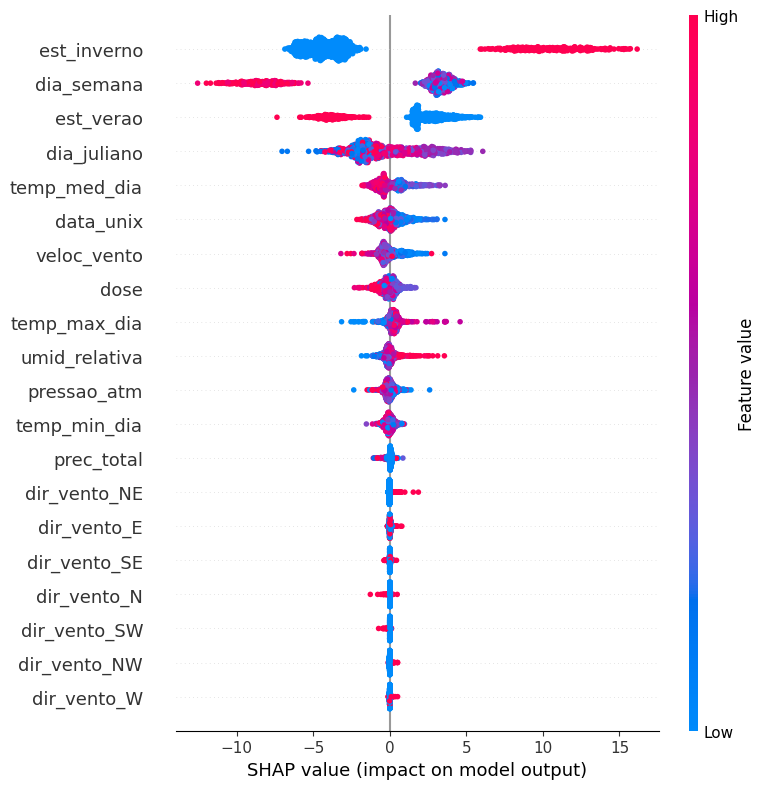

In [13]:
# Baixar e instalar o pacote SHAP (não é incluido no Google Colab)
!pip install -q shap
import shap

# Interpretação do modelo usando SHAP
explainer = shap.TreeExplainer(model)

# Cáculo dos valores SHAP
shap_values = explainer.shap_values(X)

# Visualização (resumo)
shap.summary_plot(shap_values, X, feature_names=X.columns, plot_size=[8, 8])

In [17]:
# Visualização ("force")
shap.plots.initjs()

shap.force_plot(explainer.expected_value, shap_values[270,:], X.iloc[270,:], feature_names=X.columns)

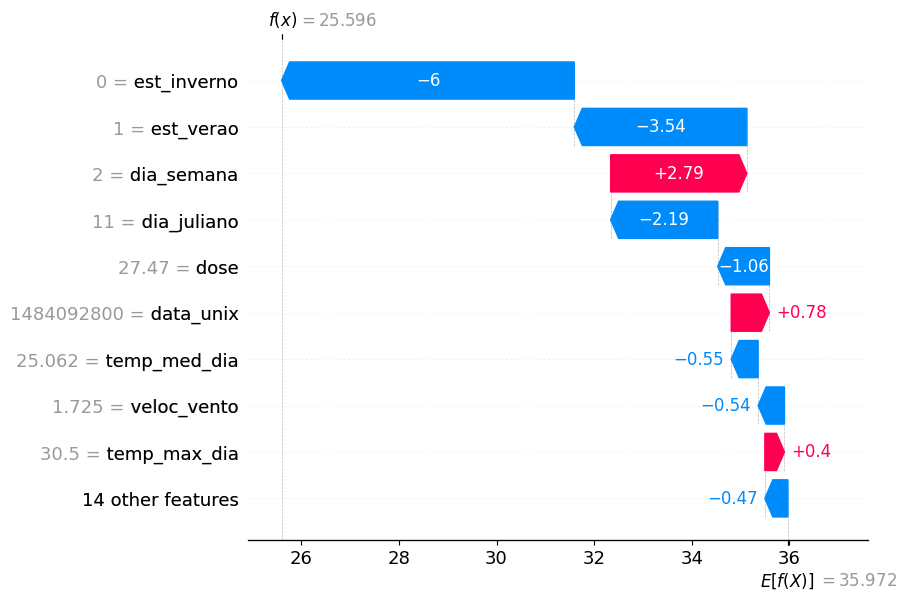

In [18]:
# Visualização ("waterfall")
explanation = shap.Explanation(shap_values[10], explainer.expected_value, X.iloc[10])

shap.plots.waterfall(explanation)

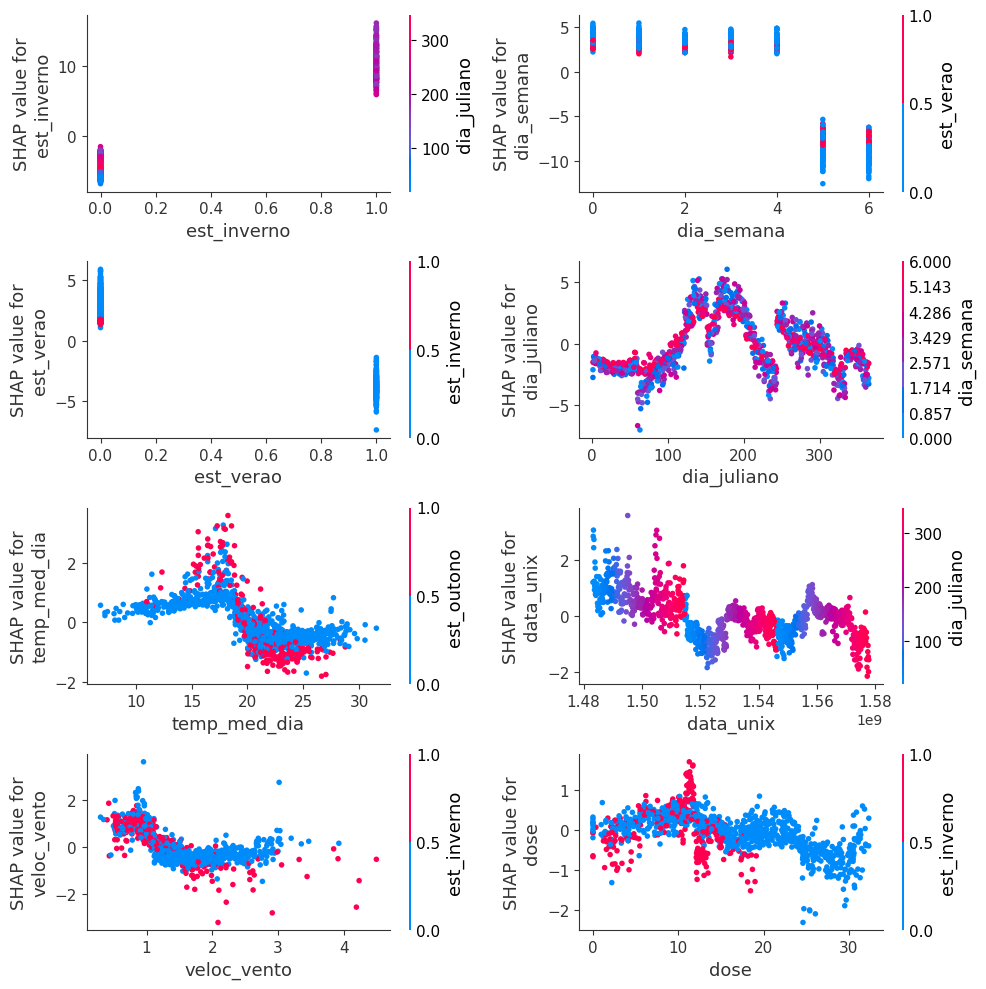

In [19]:
# Visualização (gráficos de dependência)

# Ordenar as variáveis por ordem de importância
top_inds = np.argsort(-np.sum(np.abs(shap_values), 0))[:8]

fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(10, 10))
axes = axes.ravel()

for i, col in enumerate(top_inds):
    shap.dependence_plot(top_inds[i], shap_values, X, ax=axes[i], feature_names=X.columns, show=False)

plt.tight_layout()
plt.show()